# Exploring the `sdc_paths` feature in WOMD

`sdc_paths` are a new WOMD feature indicating example valid future routes that the self-driving car (SDC) could take. Available in versions v1.3.1 and above.

Let's explore!

In [ ]:
from waymax import config as waymax_config
from waymax.dataloader import womd_dataloader
from waymax import visualization

import numpy as np
from waymax.visualization import utils as viz_utils

import dataclasses
import itertools

import jax
import matplotlib
import matplotlib.pyplot as plt
import mediapy
import pprint

First, we'll load up an interesting scenario:

INFO:2025-08-11 21:13:37,433:jax._src.xla_bridge:821: Unable to initialize backend 'tpu': UNKNOWN: TPU initialization failed: No jellyfish device found.


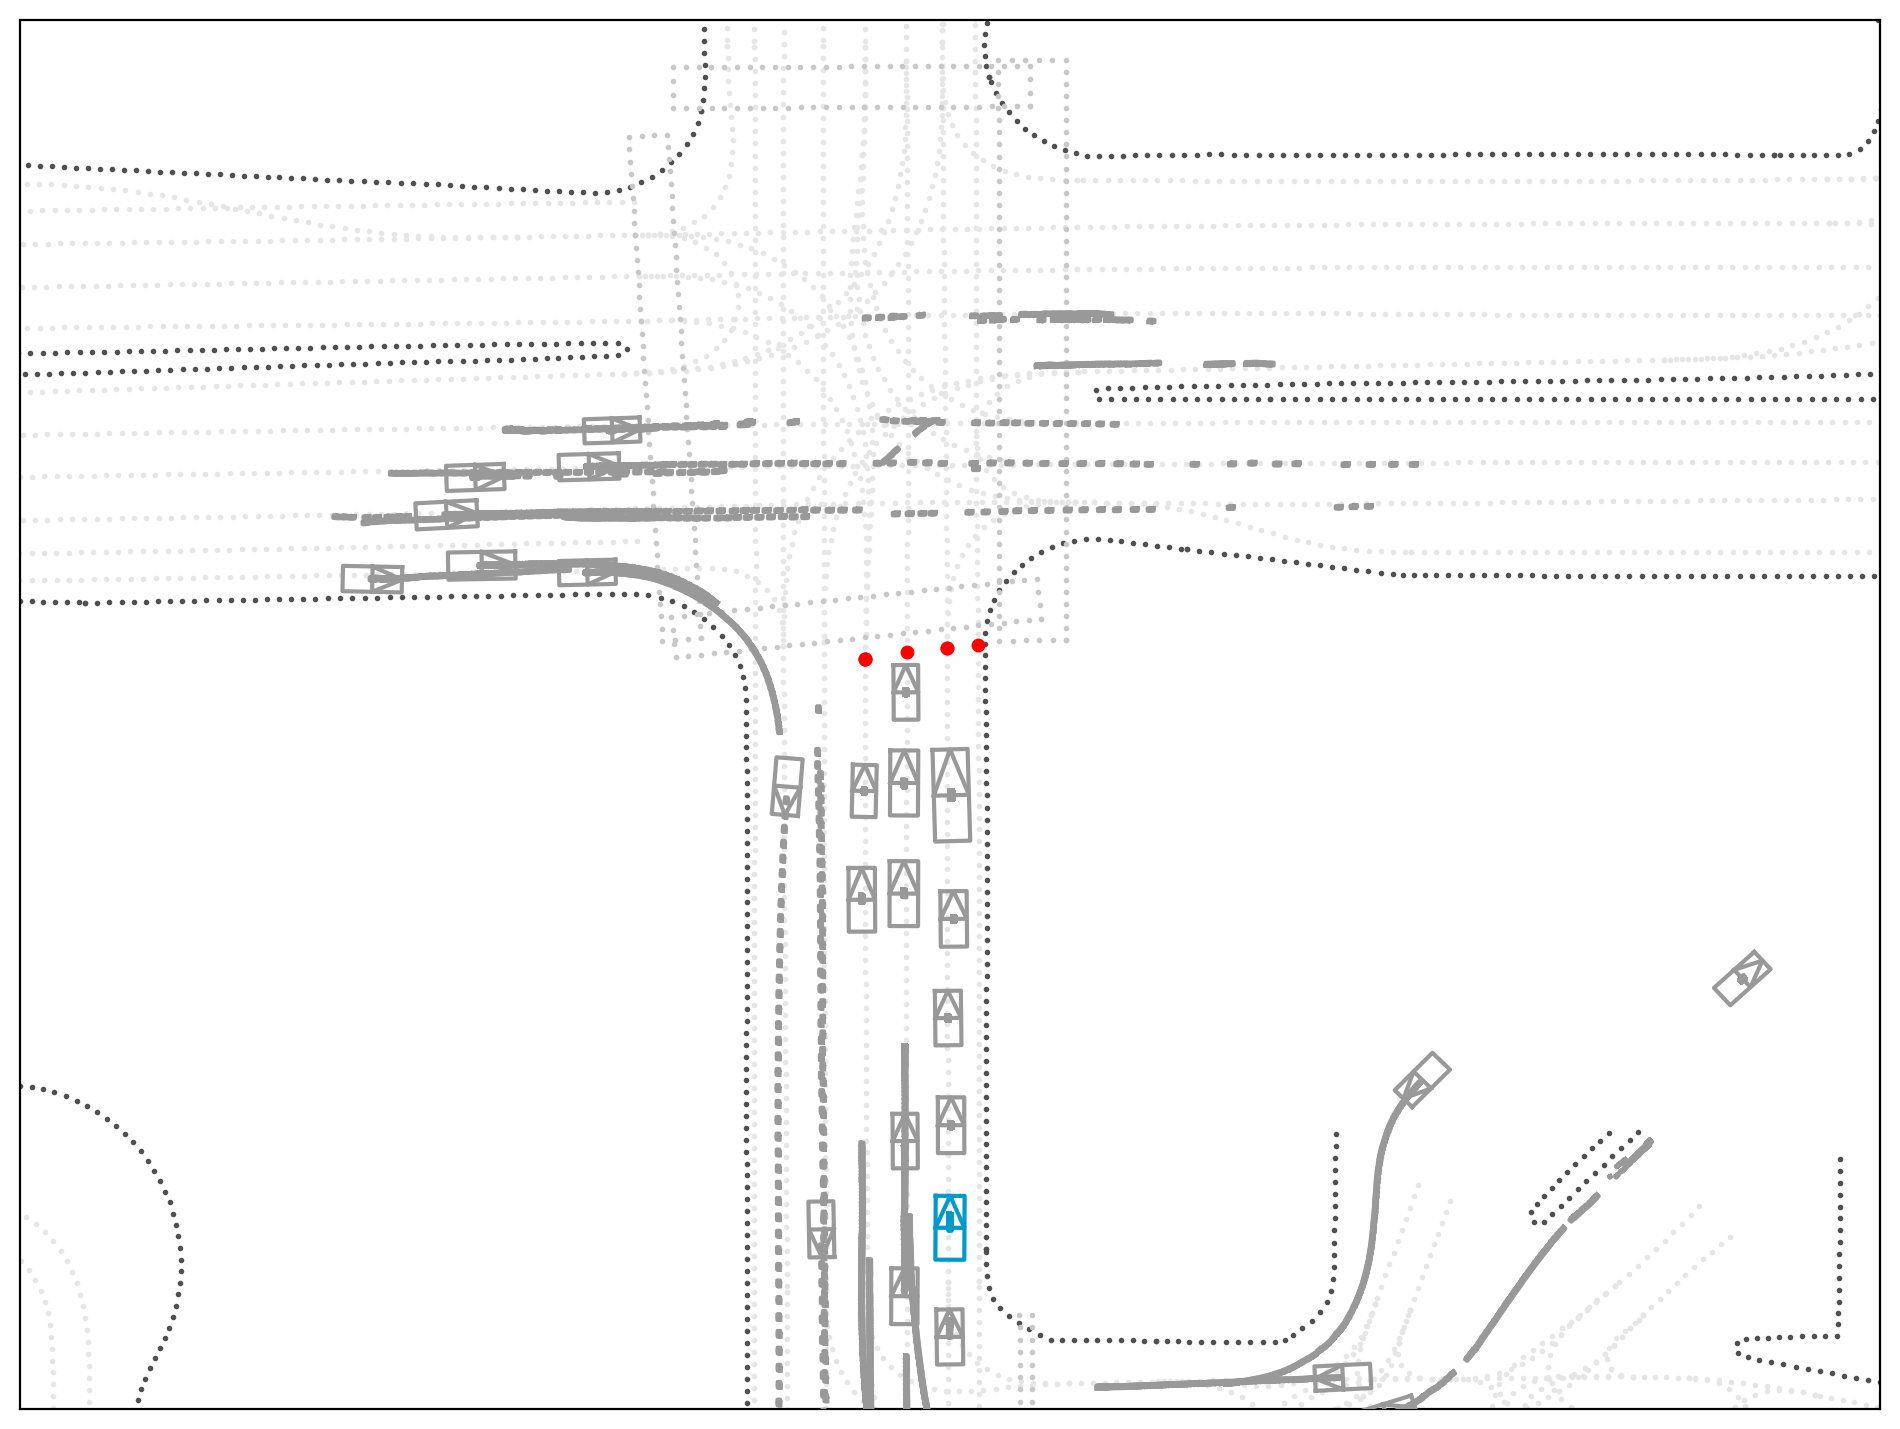

In [2]:
config = waymax_config.WOD_1_3_1_TRAINING
data_iter = womd_dataloader.simulator_state_generator(config=config)
scenario = next(itertools.islice(data_iter, 3, None))
assert scenario.sdc_paths is not None

viz_config = viz_utils.VizConfig(front_y=100, back_y=15, show_agent_id=False, px_per_meter=8)
fig, ax = viz_utils.init_fig_ax(viz_config)
visualization.plot_simulator_state_matplotlib(ax, scenario, viz_config, use_log_traj=True)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Inspecting sdc_paths

Recall that Waymax represents road scenes as [`SimulatorState`](https://github.com/waymo-research/waymax/blob/48b33d71aac20a22db7d25f2d3220596899d944a/waymax/datatypes/simulator_state.py#L43) values that capture the past, present, and future positions of all agents, the roadgraph, and the state of things like traffic lights.

Let's take a peek under the hood of `scenario`:

In [124]:
[(k, type(v)) for k, v in scenario.items()]

[('sim_trajectory', waymax.datatypes.object_state.Trajectory),
 ('log_trajectory', waymax.datatypes.object_state.Trajectory),
 ('log_traffic_light', waymax.datatypes.traffic_lights.TrafficLights),
 ('object_metadata', waymax.datatypes.object_state.ObjectMetadata),
 ('timestep', jax.jaxlib._jax.ArrayImpl),
 ('sdc_paths', waymax.datatypes.route.Paths),
 ('roadgraph_points', waymax.datatypes.roadgraph.RoadgraphPoints),
 ('roadgraph_polylines', NoneType)]

Notice that `scenario.sdc_paths` is now a [`Paths`](https://github.com/waymo-research/waymax/blob/48b33d71aac20a22db7d25f2d3220596899d944a/waymax/datatypes/route.py#L26) instance, thanks to our usage of `include_sdc_paths=True` with a compatible version of the WOMD dataset! Let's zoom in on what `scenario.sdc_paths` looks like:

In [91]:
pprint.pprint(jax.tree.map(lambda x: (str(x.dtype), x.shape), scenario.sdc_paths))

Paths(x=('float32', (45, 800)),
      y=('float32', (45, 800)),
      z=('float32', (45, 800)),
      ids=('int32', (45, 800)),
      valid=('bool', (45, 800)),
      arc_length=('float32', (45, 800)),
      on_route=('bool', (45, 1)))


In this case we have (maximum) 45 SDC paths of (maximum) 800 points each. In detail:
- `x`, `y`, `z` denote the coordinates of points in each path.
- `ids` contains integer identifiers denoting which "road part" a point belongs to. Each lane, turn, and so forth is assigned a "road part" with a unique ID.
- `valid` denotes whether each point is valid or not. A point can be invalid either because a trajectory has ended, ie. some suffix of a row in `valid` is all `False`, or because the trajectory itself is invalid, ie. every entry in a row of `valid` is `False`.
- `arc_length` denotes the length of the SDC path from the starting position to a particular step in the path. For example, `arc_length[i, 17] == 5.2` would indicate that on the `j`'th step of the `i`'th SDC path, the SDC would have travelled 5.2 meters.
- `on_route` denotes whether or not each SDC path is compatible with the SDC's observed route.

Let's plot all possible sdc_paths in blue on top of the current scene:

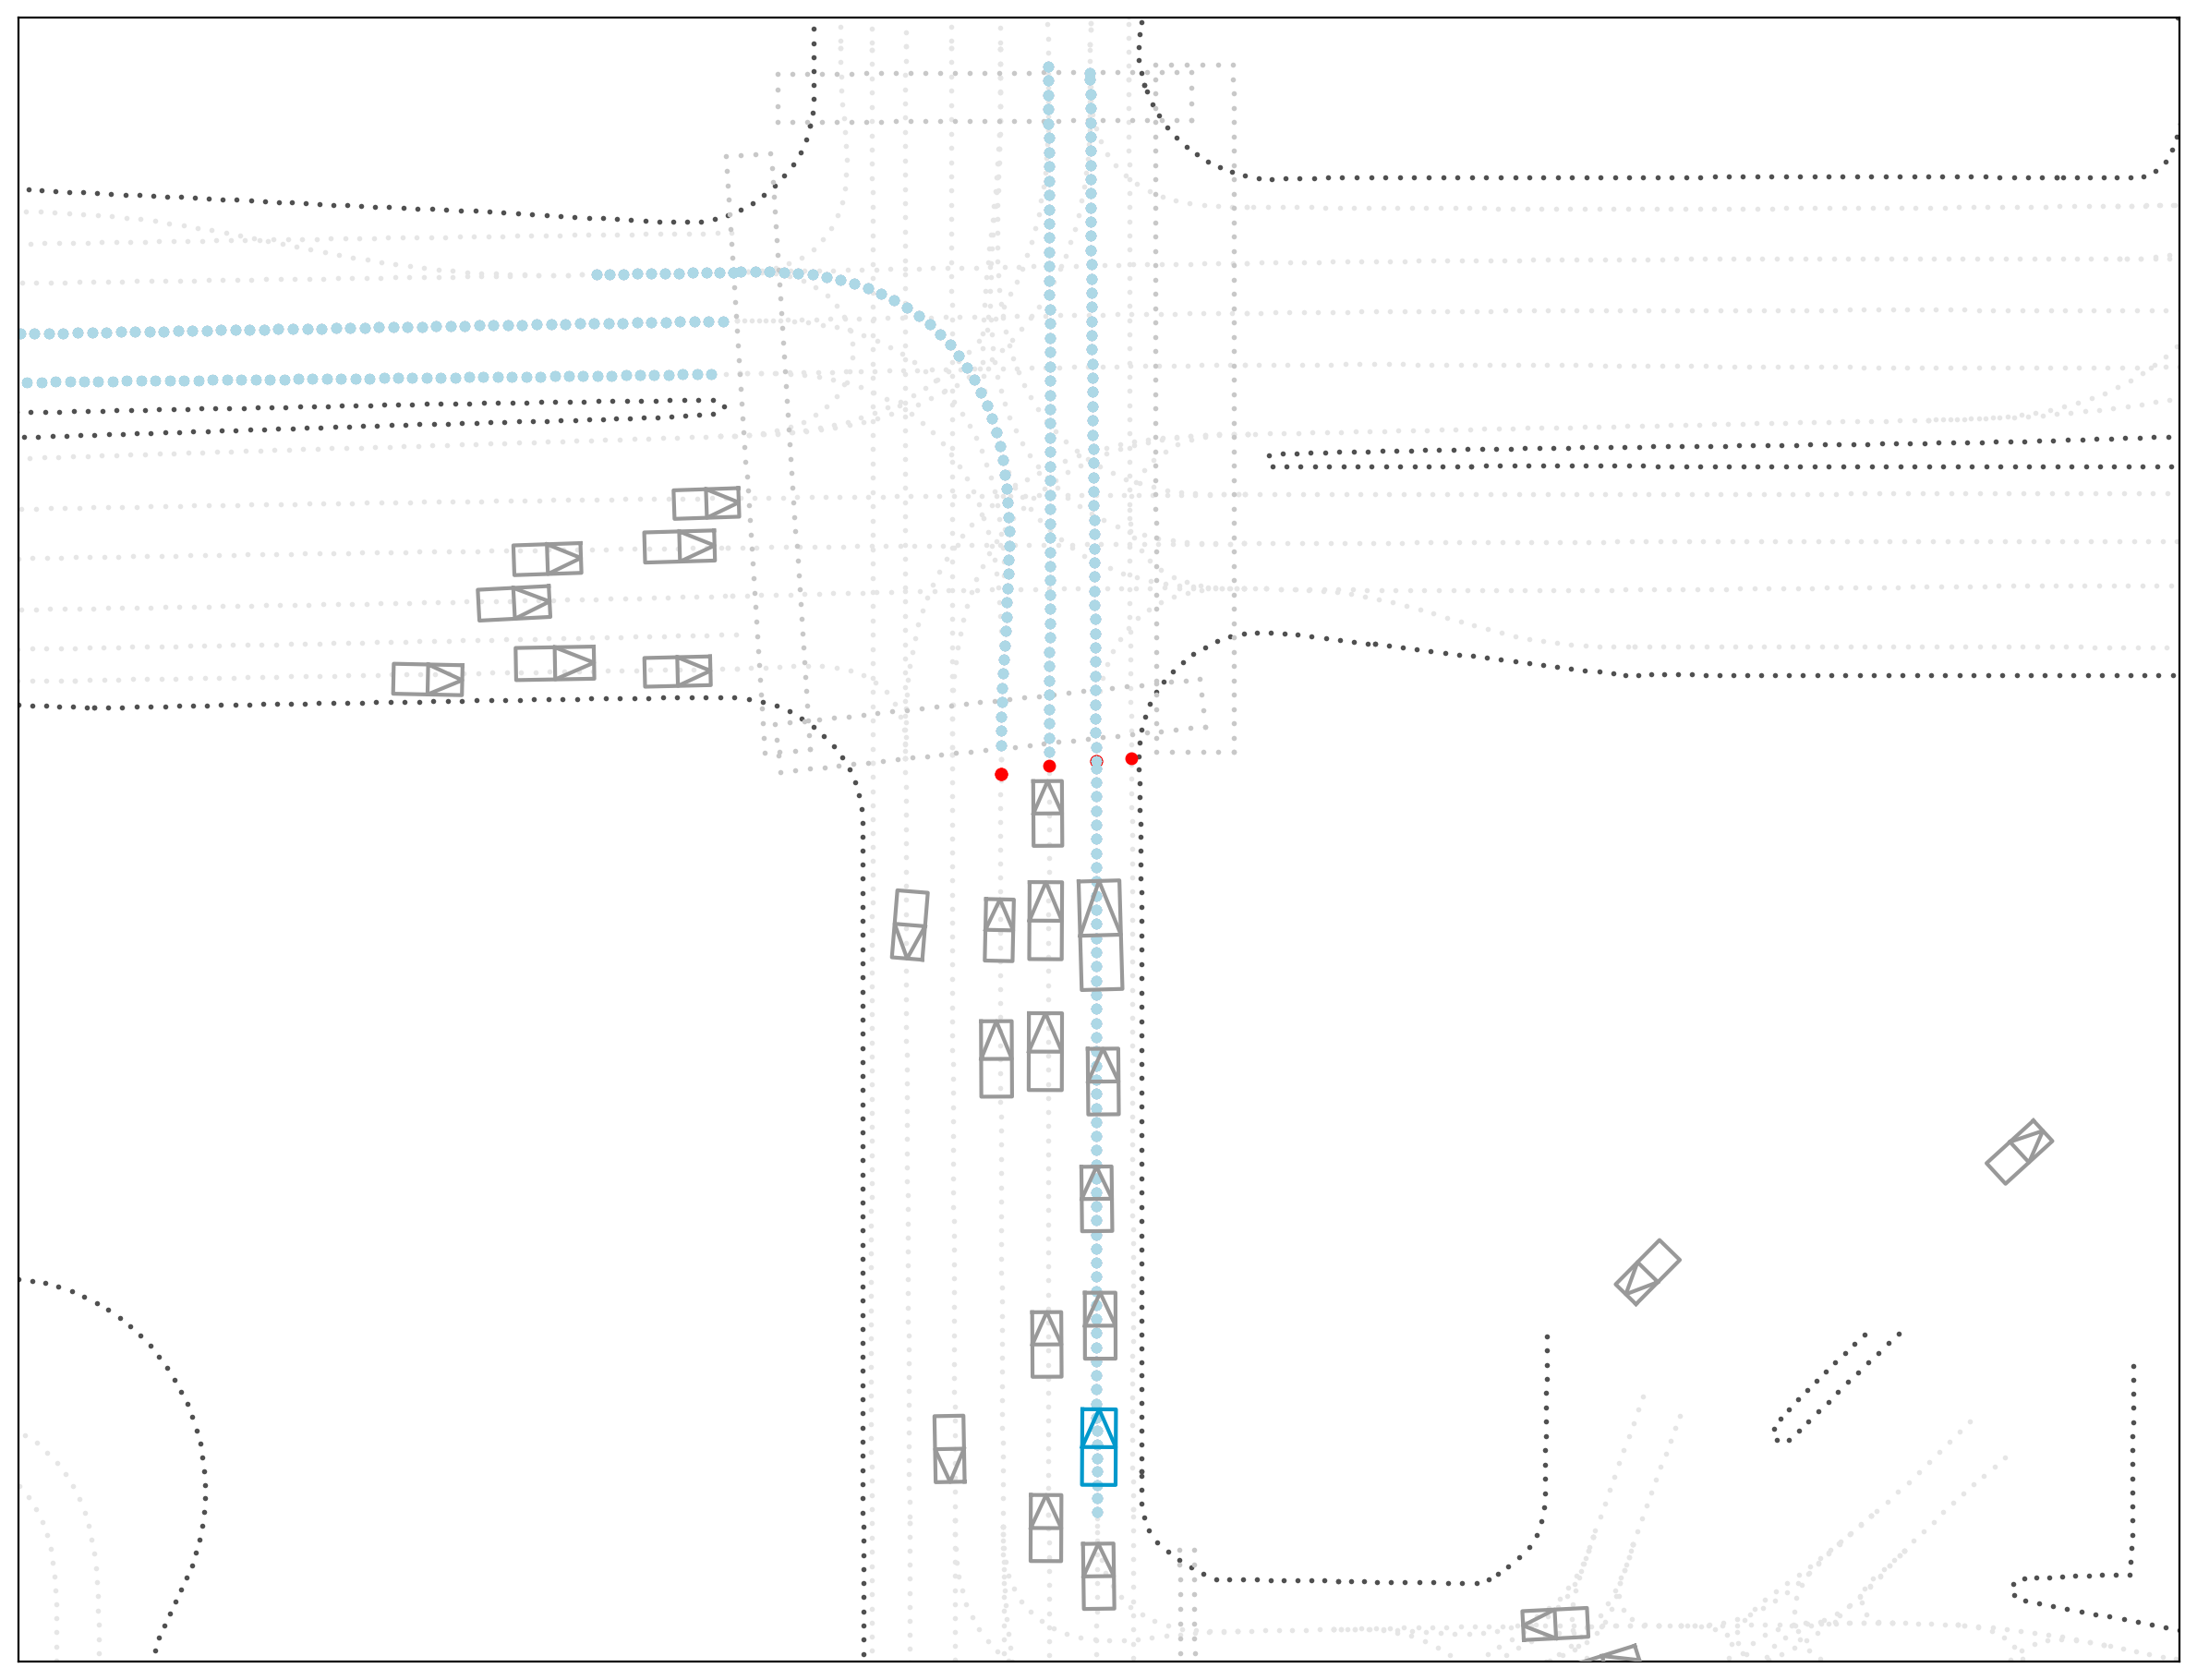

In [3]:
fig, ax = viz_utils.init_fig_ax(viz_config)
visualization.plot_simulator_state_matplotlib(ax, scenario, viz_config, use_log_traj=False)
for i in range(scenario.sdc_paths.x.shape[0]):
  num_steps = np.sum(scenario.sdc_paths.valid[i, :])
  assert np.all(scenario.sdc_paths.valid[i, :num_steps])
  ax.plot(scenario.sdc_paths.x[0, :num_steps], scenario.sdc_paths.y[0, :num_steps], '.', color='lightblue')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()

## Plotting individual paths

Now, let's try plotting the SDC paths individually:

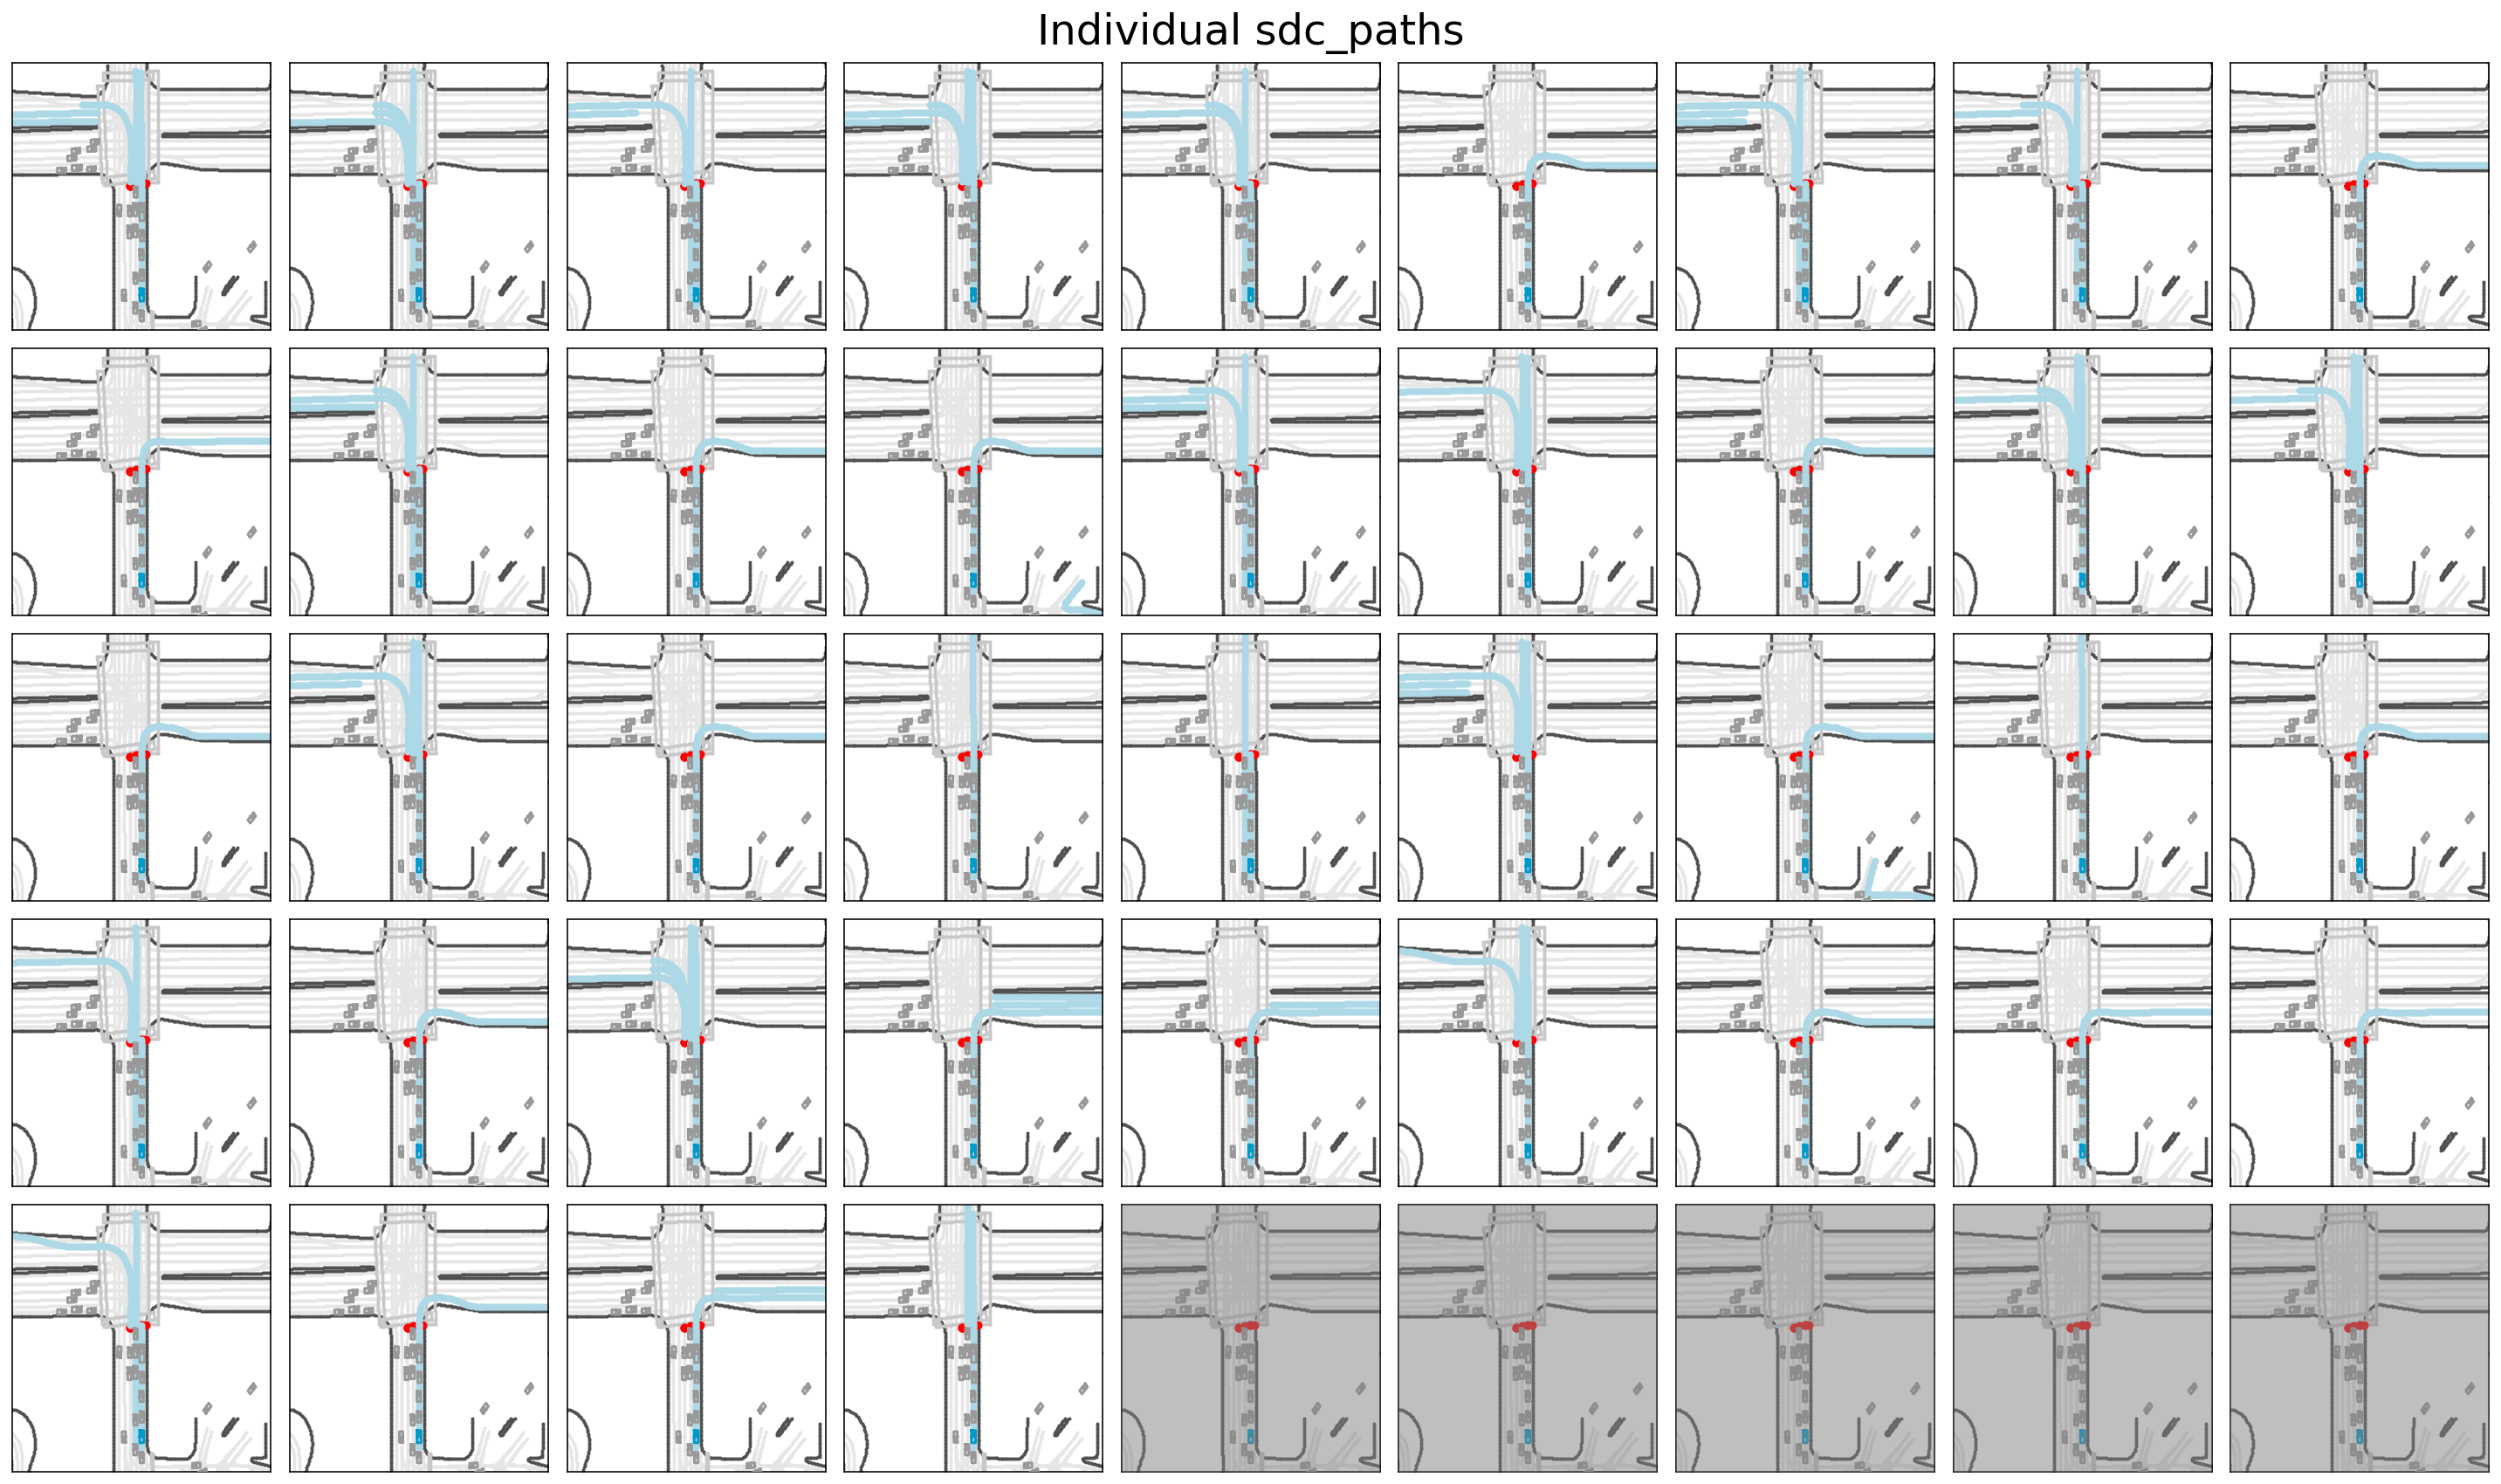

In [4]:
# Create a 5x9 grid of subplots
fig, axes = plt.subplots(5, 9, figsize=(20, 12))
axes_flat = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, ax in enumerate(axes_flat):
  # Plot the base simulator state on each subplot
  visualization.plot_simulator_state_matplotlib(ax, scenario, viz_config, use_log_traj=False)

  num_steps = np.sum(scenario.sdc_paths.valid[i, :])
  assert np.all(scenario.sdc_paths.valid[i, :num_steps])
  ax.plot(scenario.sdc_paths.x[i, :num_steps], scenario.sdc_paths.y[i, :num_steps], '.', color='lightblue' if scenario.sdc_paths.on_route[i, 0].item() else 'red')
  ax.set_xticks([])
  ax.set_yticks([])

  if num_steps == 0:
    ax.add_patch(matplotlib.patches.Rectangle(
        (0, 0), 1, 1,
        transform=ax.transAxes,
        facecolor='grey',
        alpha=0.5,
        zorder=1000
    ))

plt.suptitle('Individual sdc_paths', fontsize=24)
plt.tight_layout()
plt.show()

Note that each individual row in `sdc_paths` includes multiple, disjoint actual trajectories branching from the SDC's current position.

The last 5 trajectories don't have any valid points, so we grey out their visualizations.

## Plotting `ids`

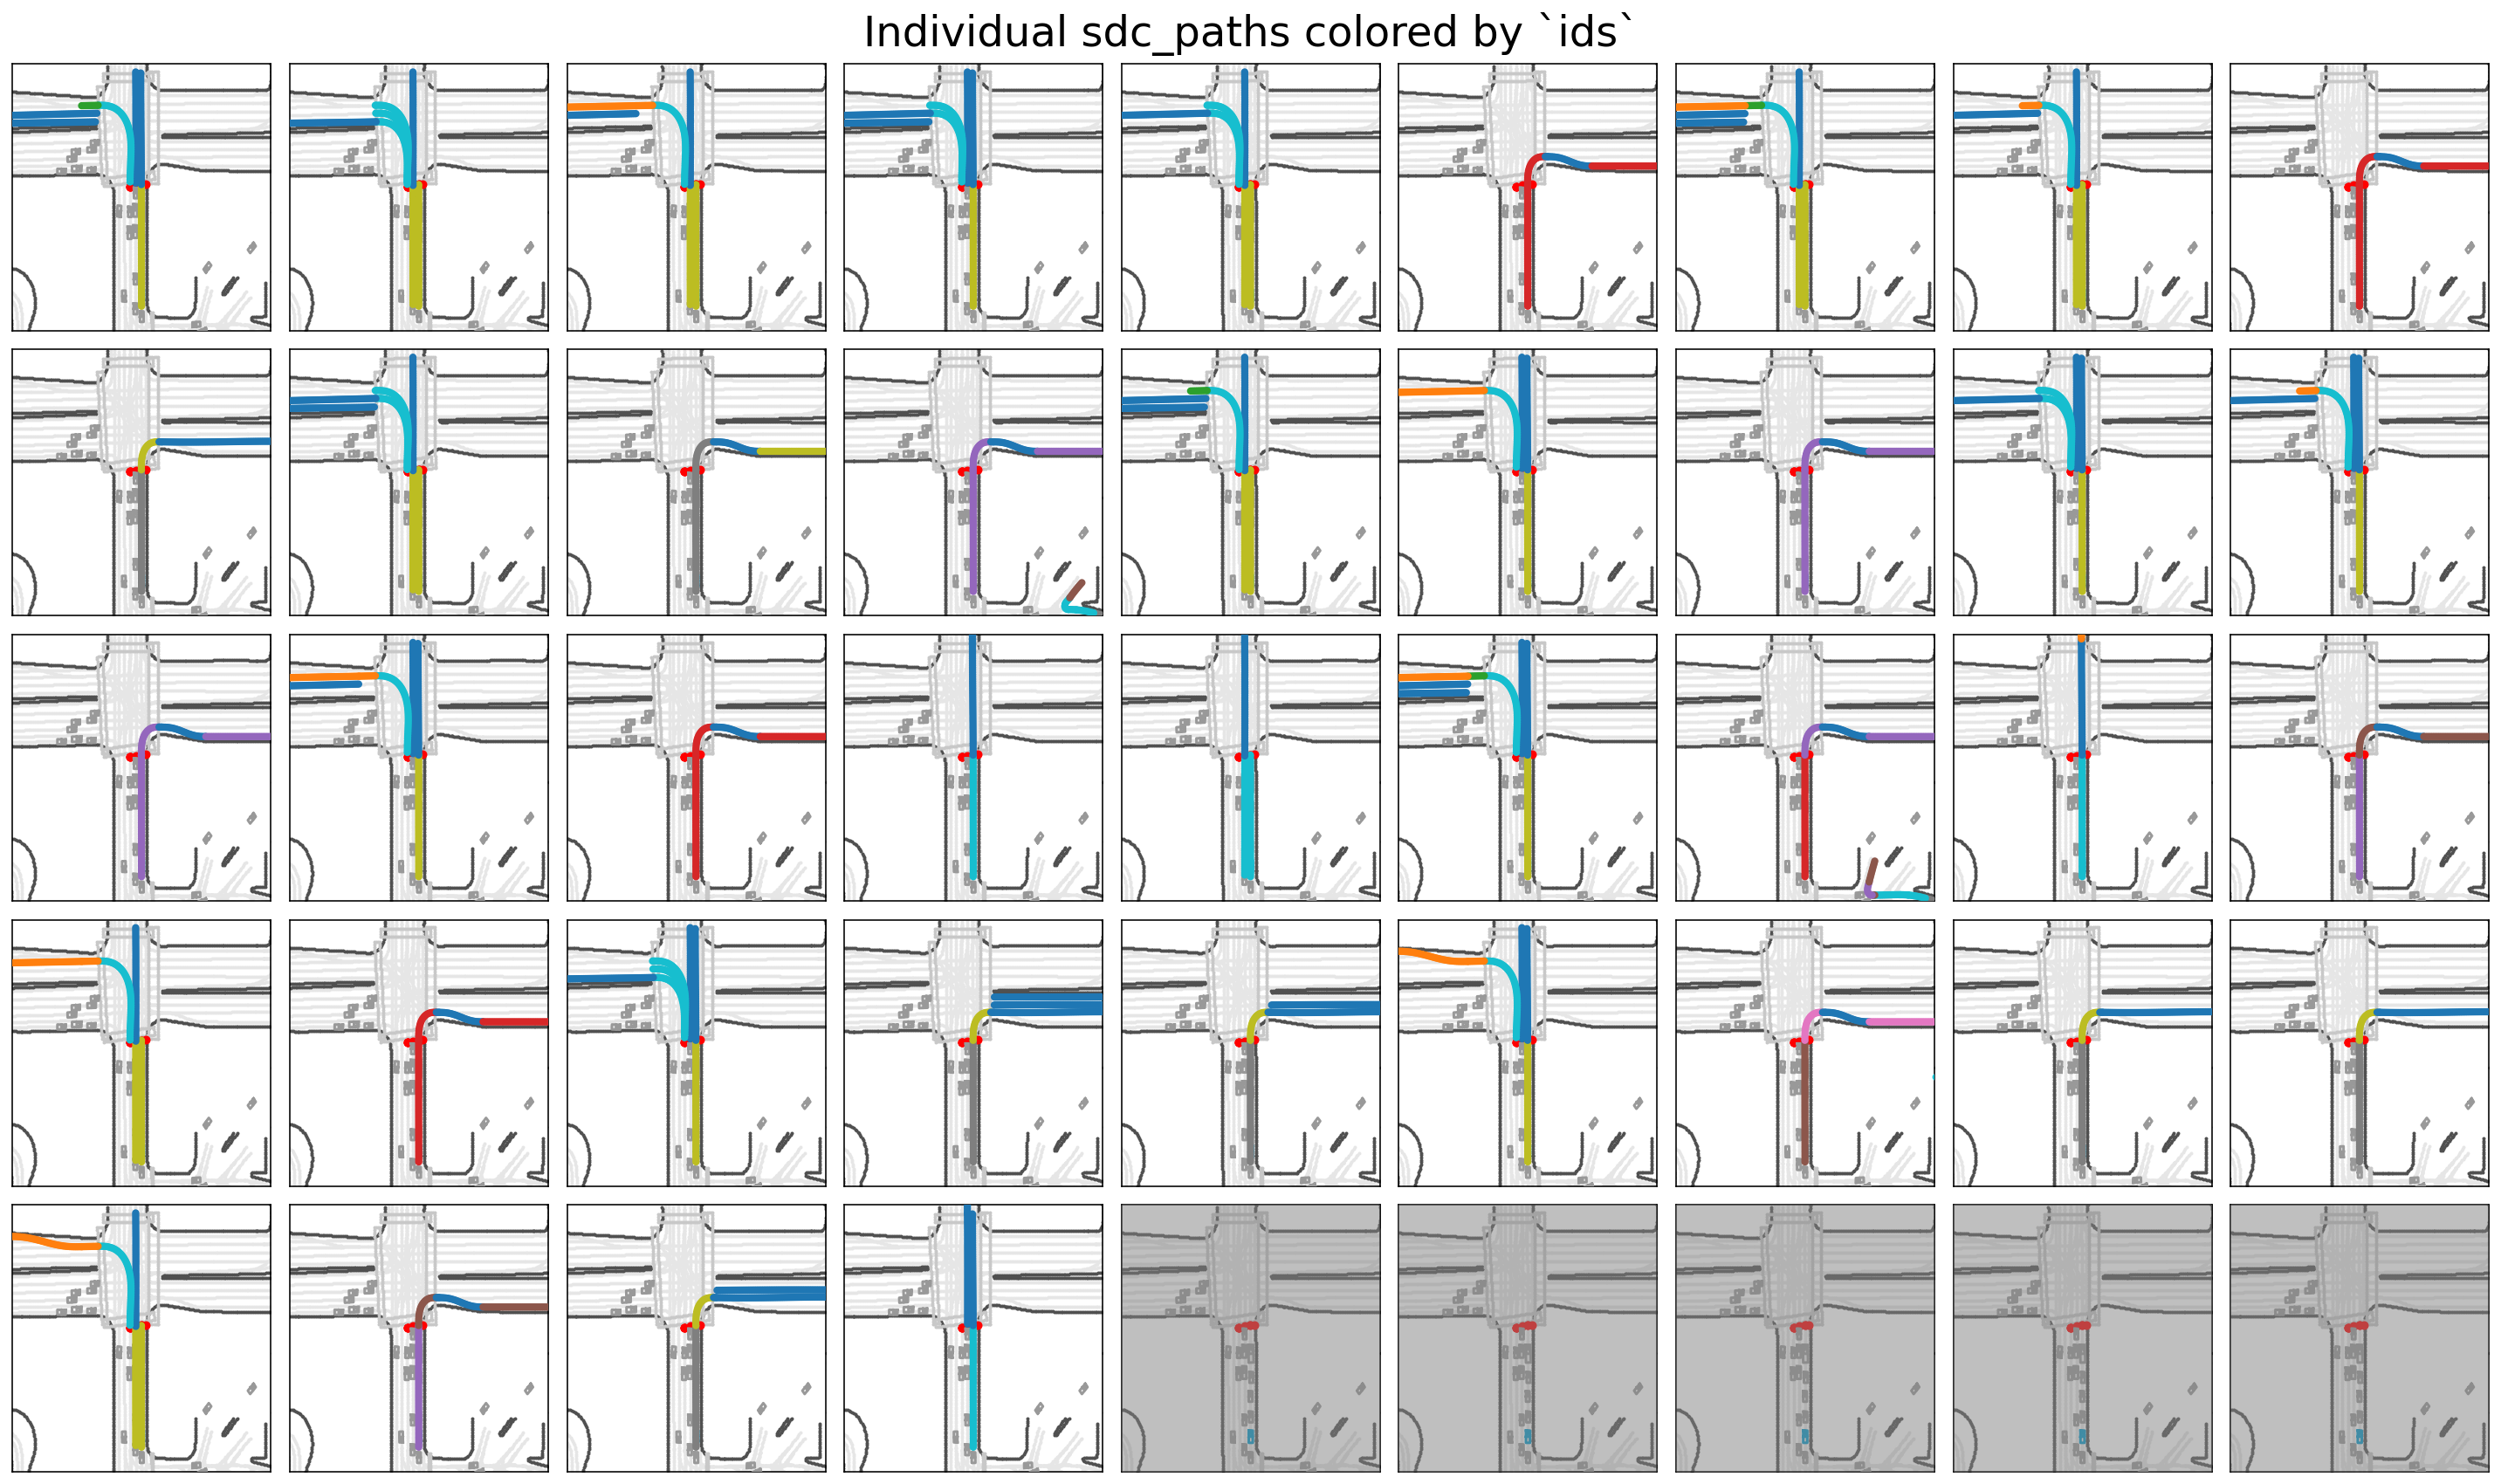

In [5]:
# Create a 5x9 grid of subplots
fig, axes = plt.subplots(5, 9, figsize=(20, 12))
axes_flat = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, ax in enumerate(axes_flat):
  # Plot the base simulator state on each subplot
  visualization.plot_simulator_state_matplotlib(ax, scenario, viz_config, use_log_traj=False)

  num_steps = np.sum(scenario.sdc_paths.valid[i, :])
  assert np.all(scenario.sdc_paths.valid[i, :num_steps])
  ax.scatter(scenario.sdc_paths.x[i, :num_steps], scenario.sdc_paths.y[i, :num_steps], c=scenario.sdc_paths.ids[i, :num_steps], s=10, zorder=100, cmap='tab10')
  ax.set_xticks([])
  ax.set_yticks([])

  if num_steps == 0:
    ax.add_patch(matplotlib.patches.Rectangle(
        (0, 0), 1, 1,
        transform=ax.transAxes,
        facecolor='grey',
        alpha=0.5,
        zorder=1000
    ))

plt.suptitle('Individual sdc_paths colored by `ids`', fontsize=24)
plt.tight_layout()
plt.show()

Note that some road parts may have duplicate colors due to the limited number of colors in the colormap, but this is only a visualization artifact.

## Plotting `arc_length`

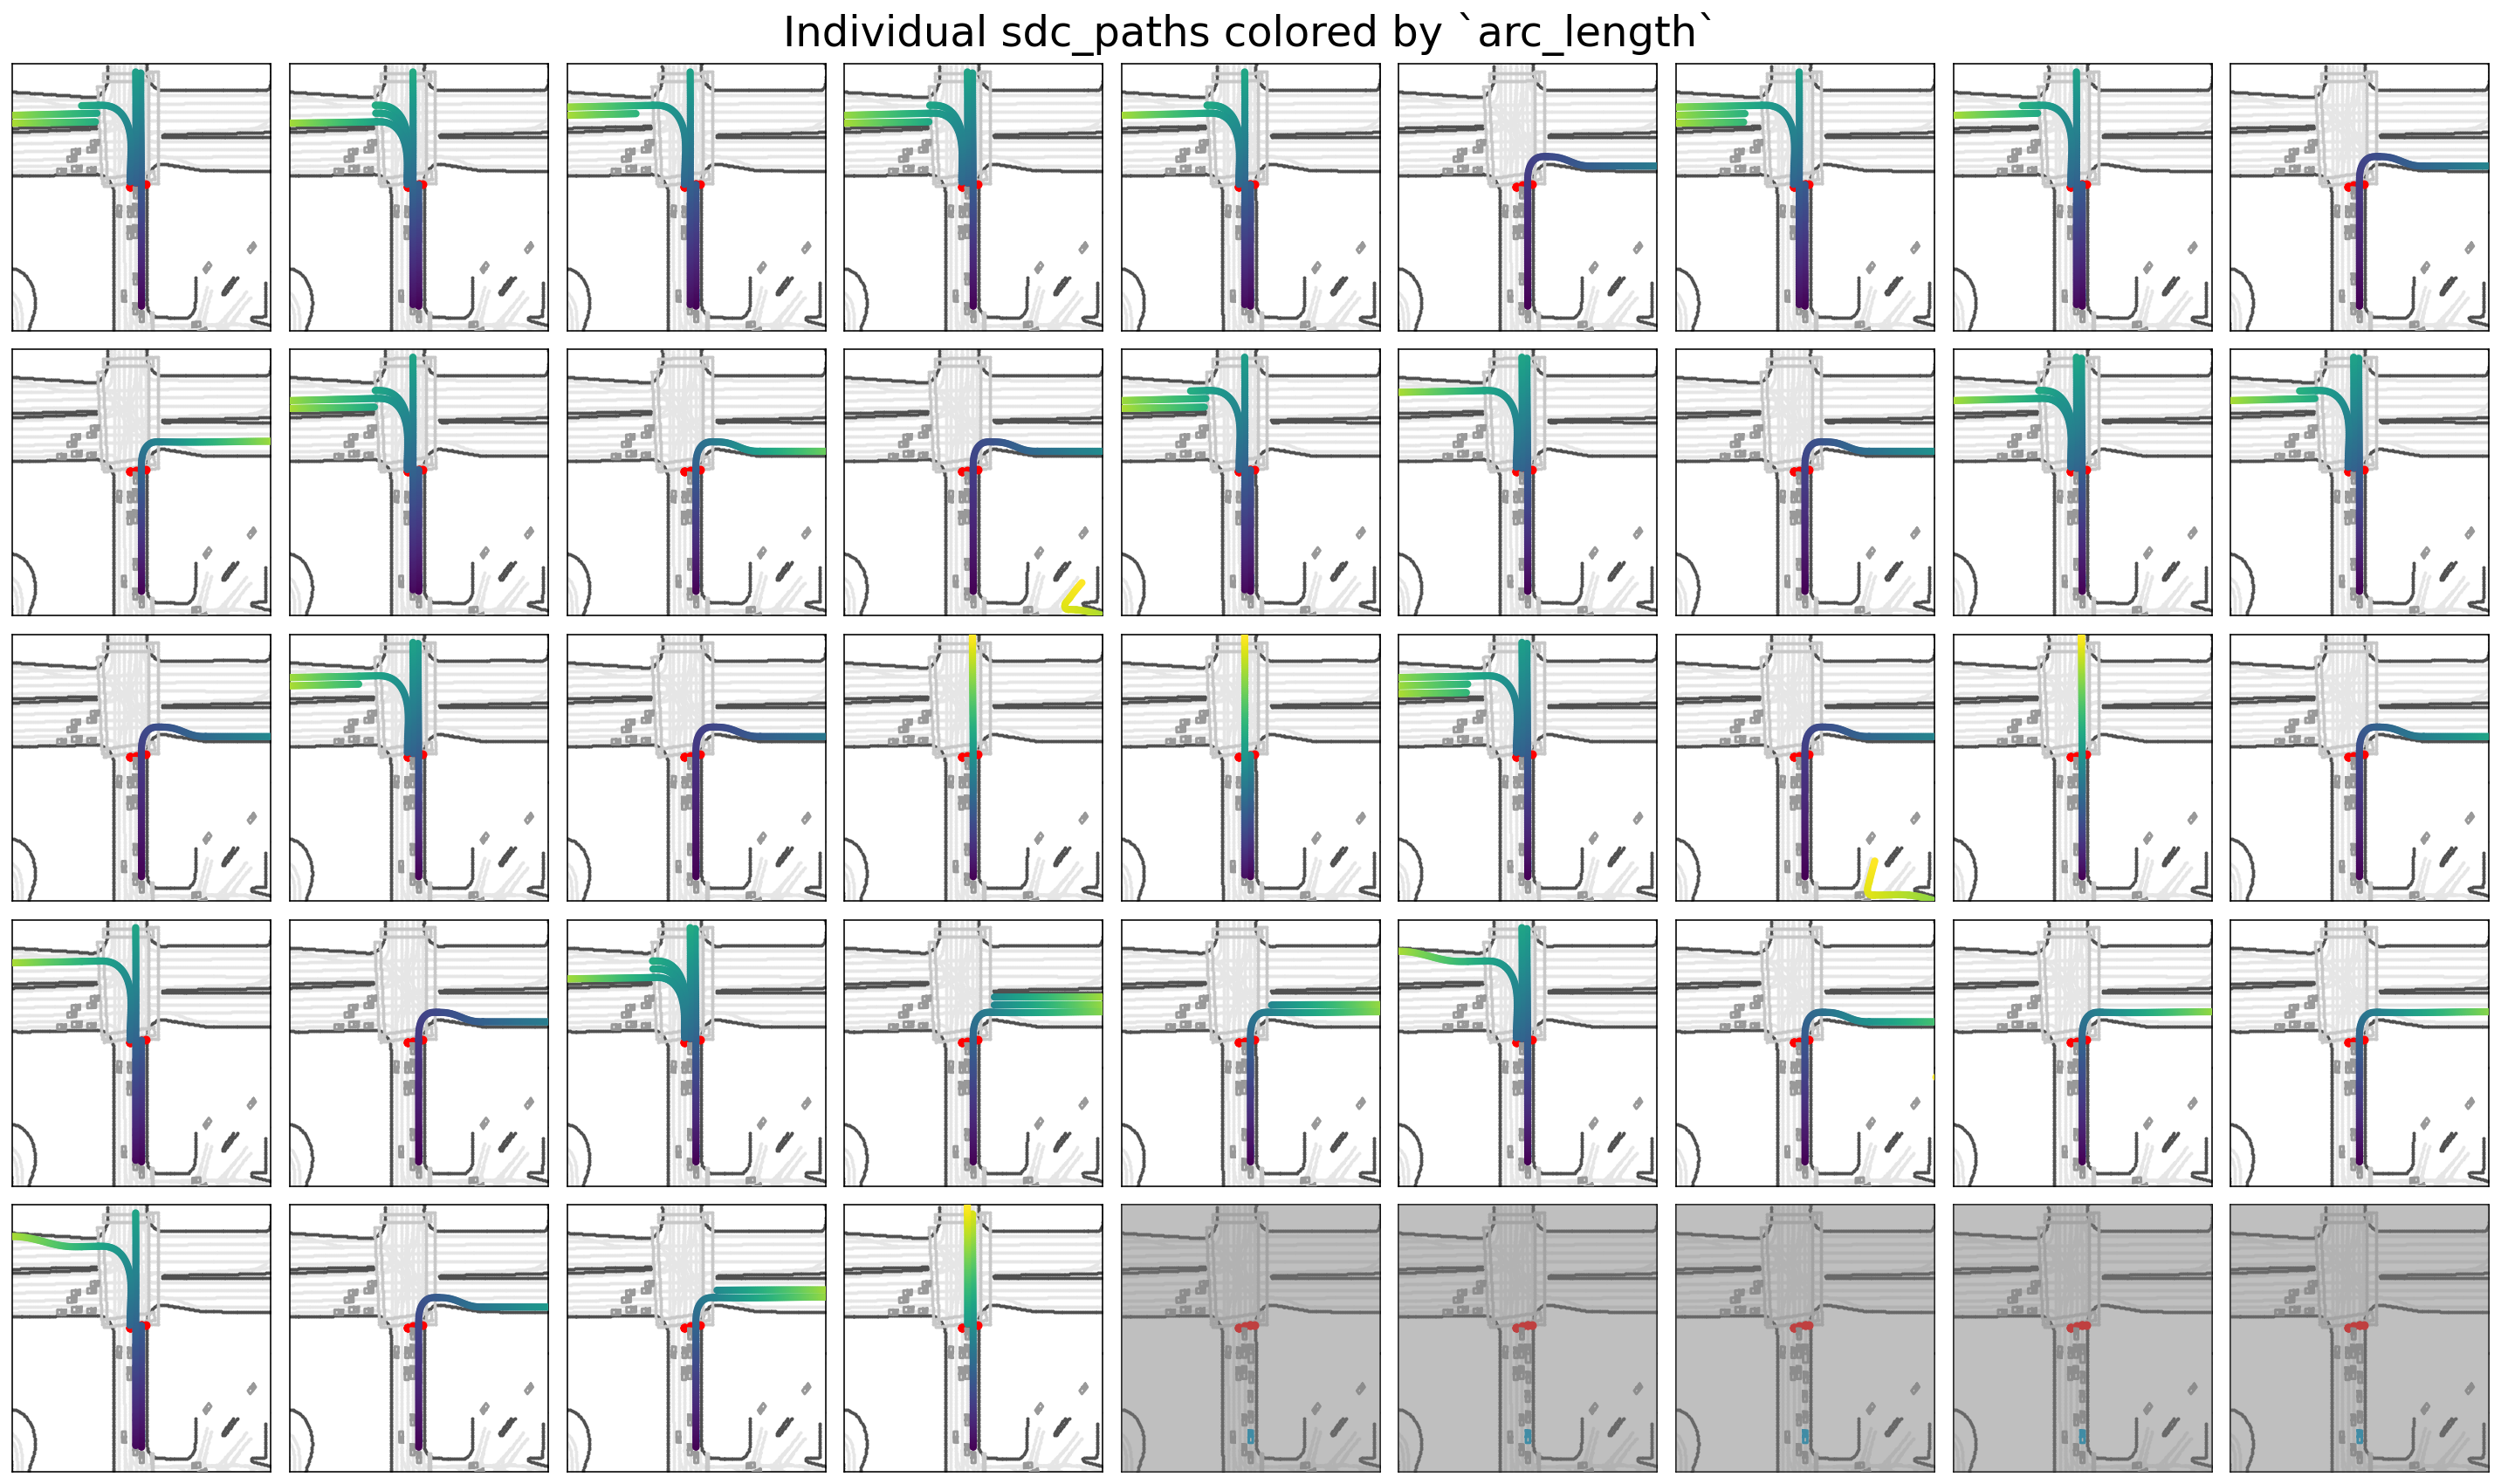

In [6]:
# Create a 5x9 grid of subplots
fig, axes = plt.subplots(5, 9, figsize=(20, 12))
axes_flat = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, ax in enumerate(axes_flat):
  # Plot the base simulator state on each subplot
  visualization.plot_simulator_state_matplotlib(ax, scenario, viz_config, use_log_traj=False)

  num_steps = np.sum(scenario.sdc_paths.valid[i, :])
  assert np.all(scenario.sdc_paths.valid[i, :num_steps])
  # Plot the i'th route on the current subplot
  ax.scatter(scenario.sdc_paths.x[i, :num_steps], scenario.sdc_paths.y[i, :num_steps], c=scenario.sdc_paths.arc_length[i, :num_steps], s=10, zorder=100)
  ax.set_xticks([])
  ax.set_yticks([])

  if num_steps == 0:
    ax.add_patch(matplotlib.patches.Rectangle(
        (0, 0), 1, 1,
        transform=ax.transAxes,
        facecolor='grey',
        alpha=0.5,
        zorder=1000  # High zorder to ensure it's on top of other elements
    ))

plt.suptitle('Individual sdc_paths colored by `arc_length`', fontsize=24)
plt.tight_layout()
plt.show()